# Medical Imaging

==============================================================================================
## Practicum 1: Computed Tomography Image Reconstruction
==============================================================================================

In this practicum, you will (1) simulate a simple phantom slice image, (2) apply Radom forward transformation to simulate the computed tomography (CT) projections over an slice (i.e. sinograms) and (3) reconstruct the original phantom intensity values using different image reconstruction algorithms.  

### Aims:
- Understand the principles of CT image reconstruction using a fan beam geometry with the aid of ``skimage``.
- Be able to generate image projections (i.e. sinograms).
- Reconstruct slices from simple and more complex objects (i.e. Shepp–Logan phantom) using back projection and iterative methods.
- Analyse and compare reconstructed data with ground truth data.
- Observe the difference between ideal (noise free) and noisy image reconstruction.

In [3]:
%matplotlib inline

In [26]:
import numpy as np
import matplotlib.pyplot as plt
from skimage.transform import radon, iradon

### 2.1 Create a simple and homogeneous phantom (1.5 points)

Create a 2D simple (digital) phantom which contains a fake lesion as shown below:

<img src='images_4_notebook/SimplePhantom.png' width="200">

- Phantom size (rows x columns): 256 x 256 pixels.
- Phantom must contain 3 tissues with the following labels:
    - Background = 0 pixel intensity value
    - Tissue 1 = 1 (radius = 100 pixels)
    - Tissue 2 (lesion) = 2 (radius = 5 pixels)
    
Help: To create the circunferences, you can use the function ``create_circular_mask``, or define your own function. The lesion could be located in any position within the phantom except for the central position of the phantom.

Once constructed, plot the original phantom (``plt.imshow``) and a pixel intensity horizontal profile (``plot``) along the lesion. Always remember to include the units of the axis when ploting a graph.

In [5]:
def create_circular_mask(h, w, center=None, radius=None):

    if center is None: # use the middle of the image
        center = (int(w/2), int(h/2))
    if radius is None: # use the smallest distance between the center and image walls
        radius = min(center[0], center[1], w-center[0], h-center[1])

    Y, X = np.ogrid[:h, :w]
    dist_from_center = np.sqrt((X - center[0])**2 + (Y-center[1])**2)

    mask = dist_from_center <= radius
    return mask
# https://newbedev.com/how-can-i-create-a-circular-mask-for-a-numpy-array

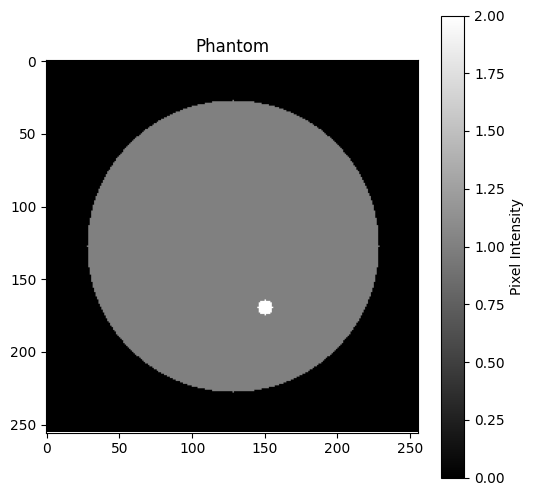

In [6]:
# 1. BACKGROUND

h, w = 256,256  #This is the phantom size
phantom = np.zeros((h, w))  #we create the background 


# 2. TISSUE 1 AND LESION

mask_tissue_1 = create_circular_mask(h, w, radius=100)
phantom[mask_tissue_1] = 1 #We set the intensity to 1



lesion = (150, 170) #We randomly select this position for the lesion
mask_lesion = create_circular_mask(h, w, center=lesion, radius=5)
phantom[mask_lesion] = 2  #We set the intensity to 2


# 3. DISPLAY PHANTOM

plt.figure(figsize=(6, 6))
plt.imshow(phantom, cmap='gray')
plt.title('Phantom')
plt.colorbar(label='Pixel Intensity')
plt.show()

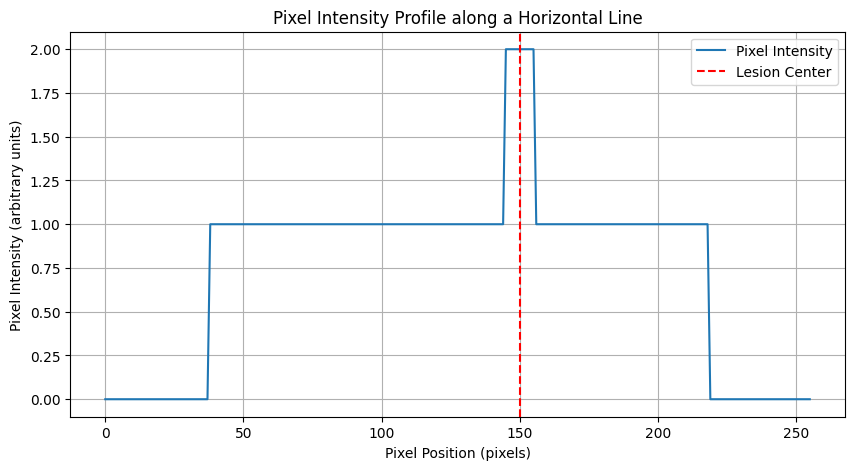

In [7]:
# PIXEL INTENSITY HORIZONTAL PROFILE 


pixel_intensity_profile = phantom[lesion[1], :] 

plt.figure(figsize=(10, 5))
plt.plot(pixel_intensity_profile, label='Pixel Intensity')
plt.axvline(x=lesion[0], color='r', linestyle='--', label='Lesion Center')
plt.title('Pixel Intensity Profile along a Horizontal Line')
plt.xlabel('Pixel Position (pixels)')
plt.ylabel('Pixel Intensity (arbitrary units)')
plt.legend()
plt.grid(True)
plt.show()


In this plot it can be observed the changes in pixel intensity as we move across the phantom. According to the plot, there are three intensities: 0 (which means that the pixel is black, and it corresponds to the background), 1 (which is the grey colour, representing the tissue), and 2 (the white colour, which is the lesion).

### 2.2 Create the projections of the phantom (2.5 points)

Generate the projections of the previously generated phantom using the ``radon`` transform from ``skimage.transform``. Play with the different parameters to optimise sinogram. Then, show the sinogram of the projections.

In this section, considered the following 2 approches:

``A``. Use different number of projections (i.e. 4, 20, 50, 100, 200, 300, 360) considering that in all cases the simulated projections cover the 360º. For example, 100 projections are taken in the range from 0º to 360º.

``B``. Use different ranges of angles (i.e. 4º, 20º, 50º, 100º, 200º, 300º, 360º) equally distributed.  For instance, 100 projections are taken in a range of 100º.

``Questions``: What is the effect of increasing/decrasing the number of proyections? Can you comment on the difference between approach A and B?

The Radon transform is a mathematical operation that transforms a 2D image into its projections from different angles.  The resulting set of projections is often referred to as a sinogram.

In [21]:
help(radon)

Help on function radon in module skimage.transform.radon_transform:

radon(image, theta=None, circle=True, *, preserve_range=False)
    Calculates the radon transform of an image given specified
    projection angles.
    
    Parameters
    ----------
    image : array_like
        Input image. The rotation axis will be located in the pixel with
        indices ``(image.shape[0] // 2, image.shape[1] // 2)``.
    theta : array_like, optional
        Projection angles (in degrees). If `None`, the value is set to
        np.arange(180).
    circle : boolean, optional
        Assume image is zero outside the inscribed circle, making the
        width of each projection (the first dimension of the sinogram)
        equal to ``min(image.shape)``.
    preserve_range : bool, optional
        Whether to keep the original range of values. Otherwise, the input
        image is converted according to the conventions of `img_as_float`.
        Also see https://scikit-image.org/docs/dev/user_guide/

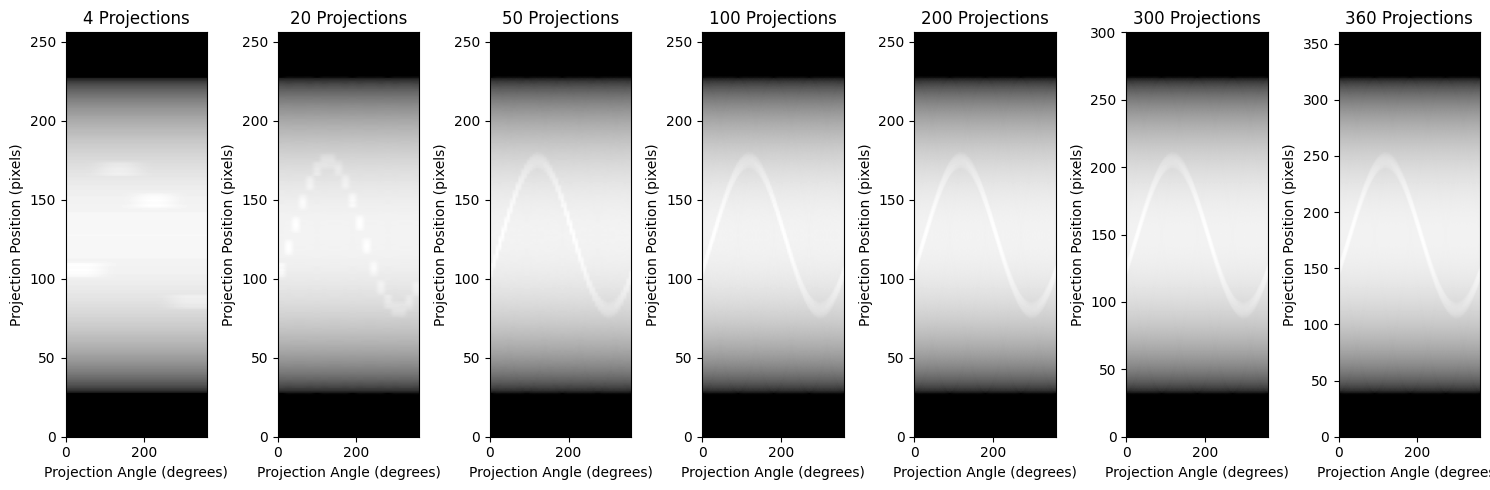

In [13]:
# APPROACH A


projections = [4, 20, 50, 100, 200, 300 , 360]  # 7 projections

def generate_sinogram(phantom, theta):
    sinogram = radon(phantom, theta=theta, circle=True)
    return sinogram


# Generate and display sinograms for Approach A

fig, axes = plt.subplots(1, len(projections), figsize=(15, 5))
for i, num_proj in enumerate(projections):
    theta = np.linspace(0., 360., num_proj, endpoint=False)
    sinogram = generate_sinogram(phantom, theta)
    axes[i].imshow(sinogram, cmap='gray', aspect='auto', extent=[0, 360, 0, max(sinogram.shape)])
    axes[i].set_title(f'{num_proj} Projections')
    axes[i].set_xlabel('Projection Angle (degrees)')
    axes[i].set_ylabel('Projection Position (pixels)')

plt.tight_layout()
plt.show()



In this approach, the angular range is always 360°, but the density of projections varies. We can see that, as the number of projections increases, the sinogram becomes clearer and more detailed, which could lead to a better reconstruciton of the image. However, we have to take into consideration that this could increase computational costs and time.

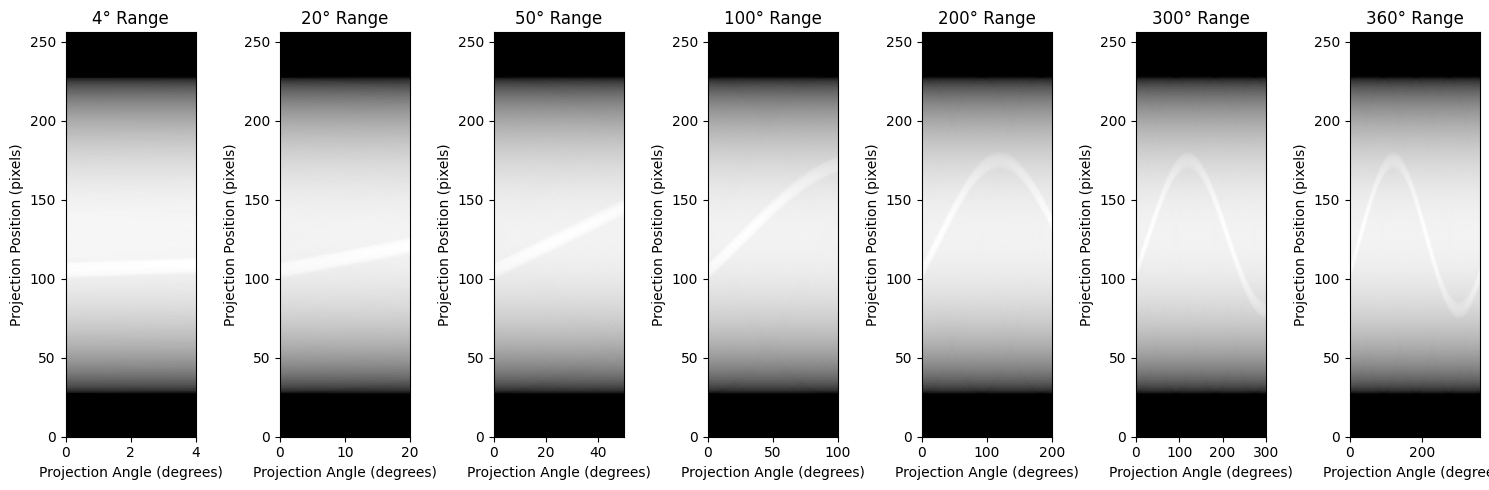

In [19]:
# APPROACH B:

angular_ranges = [4, 20, 50, 100, 200, 300, 360]
num_projections = 100  # We keep the number of projections constant


# Generate and display sinograms for Approach B
fig, axes = plt.subplots(1, len(angular_ranges), figsize=(15, 5))
for i, angular_range in enumerate(angular_ranges):
    theta = np.linspace(0., angular_range, num_projections, endpoint=False)
    sinogram = generate_sinogram(phantom, theta)
    axes[i].imshow(sinogram, cmap='gray', aspect='auto', extent=[0, angular_range, 0, max(sinogram.shape)])
    axes[i].set_title(f'{angular_range}° Range')
    axes[i].set_xlabel('Projection Angle (degrees)')
    axes[i].set_ylabel('Projection Position (pixels)')

plt.tight_layout()
plt.show()

In approach B we had a constant number of projections but changing the angular ranges. We can see that, with wider angular ranges, the sinogram captures more diverse information about the phantom and this improves the quality of the reconstructed image.

### 2.3 Reconstruction with Filtered Back Projection (FBP) (2.5 points)

FBP is one of the most simple reconstruction methods to reconstruct images in CT. Explore the ``iradon`` from ``skimage.transform`` using the different filters available (Ramp filter (default), Shepp-logan, Cosine, Hamming, Hann).

Then, show the original and reconstructed images of the phantom.

Explore the two approches (A and B) described previously.

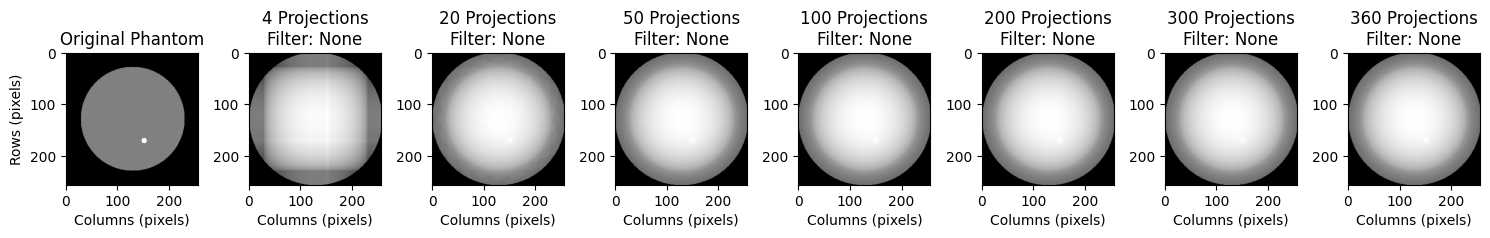

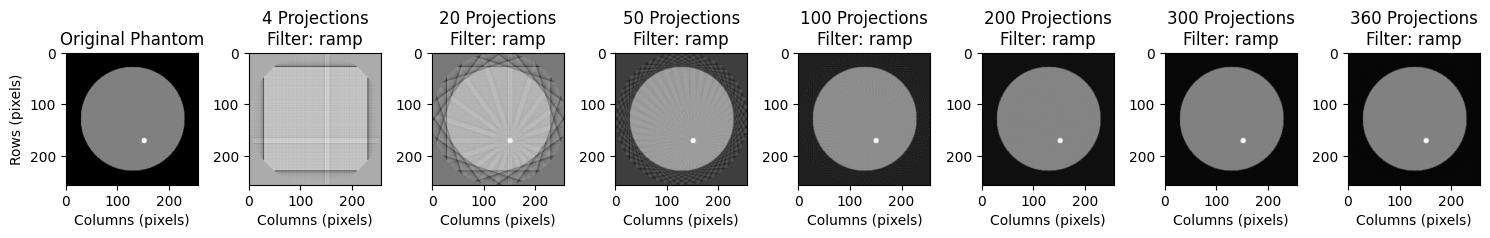

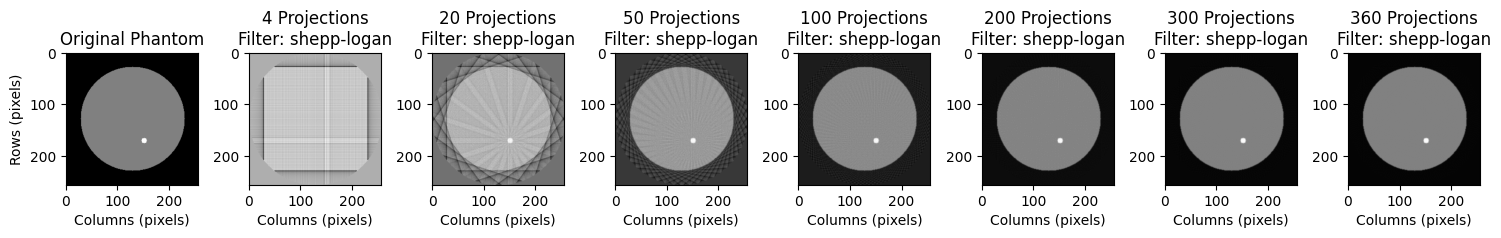

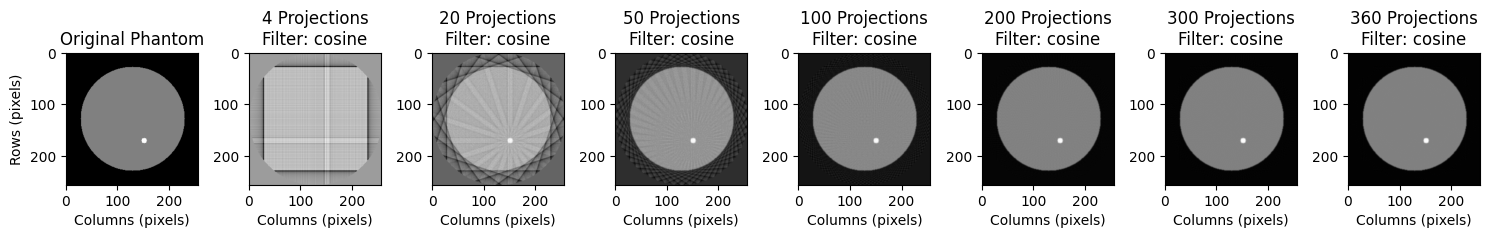

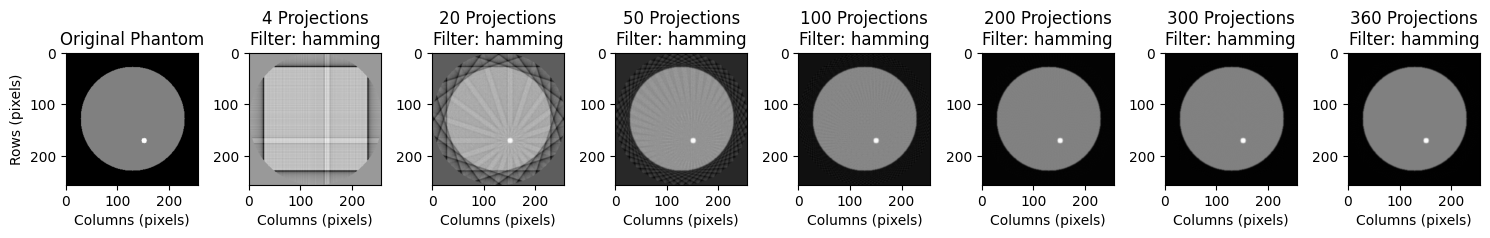

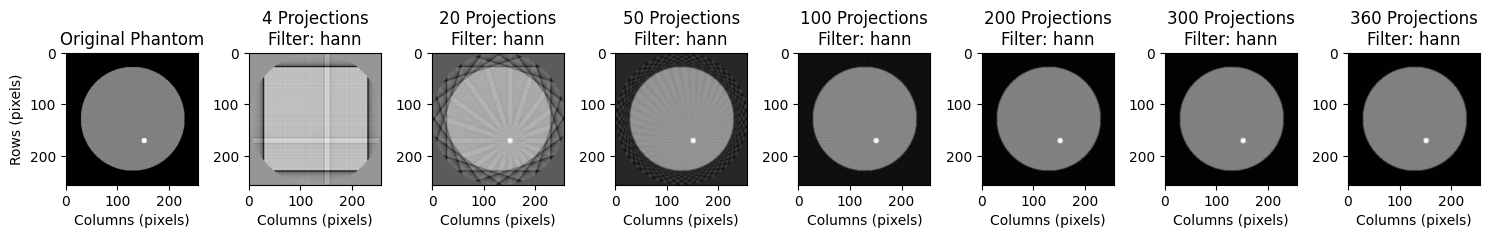

In [29]:
filters = [None, 'ramp', 'shepp-logan', 'cosine', 'hamming', 'hann']

h, w = 256, 256 #This is the phantom size


# Approach A: Varying Number of Projections
for filter_type in filters:
    fig, axes = plt.subplots(1, len(projections) + 1, figsize=(15, 5))  # +1 for the original phantom
    
    # Display original phantom
    axes[0].imshow(phantom, cmap='gray', extent=[0, w, h, 0])
    axes[0].set_title('Original Phantom')
    axes[0].set_xlabel('Columns (pixels)')
    axes[0].set_ylabel('Rows (pixels)')
    
    # Display reconstructed images
    for i, num_proj in enumerate(projections):
        theta = np.linspace(0., 360., num_proj, endpoint=False)
        sinogram = radon(phantom, theta=theta, circle=True)
        reconstruction = iradon(sinogram, theta=theta, filter_name=filter_type, circle=True)
        axes[i + 1].imshow(reconstruction, cmap='gray', extent=[0, w, h, 0])
        axes[i + 1].set_title(f'{num_proj} Projections\nFilter: {filter_type or "None"}')
        axes[i + 1].set_xlabel('Columns (pixels)')
    
    plt.tight_layout()
    plt.show()


It is possible to see that, as the number of projections increases, the quality of the reconstructed image improves. If we do not use any filter, the reconstruced image even with 360 projections it's unclear and we can not differenciate the lesion. 
However, 
Different filters have different effects on the reconstruction quality althought they might not be easy to distinguish at first sight. All of the filters are capable of reconstructing the image accordingly and we can differenciate the tissue from the lesion. 

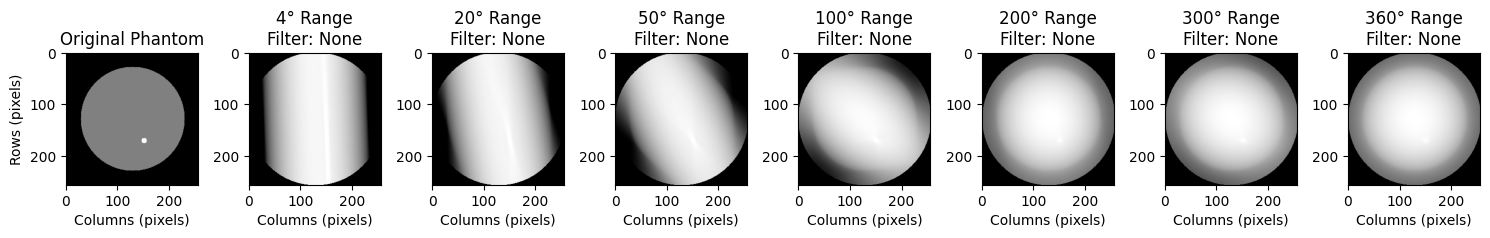

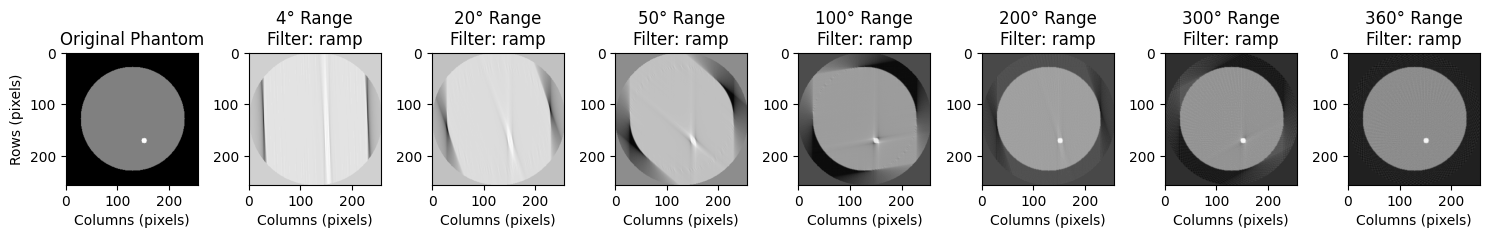

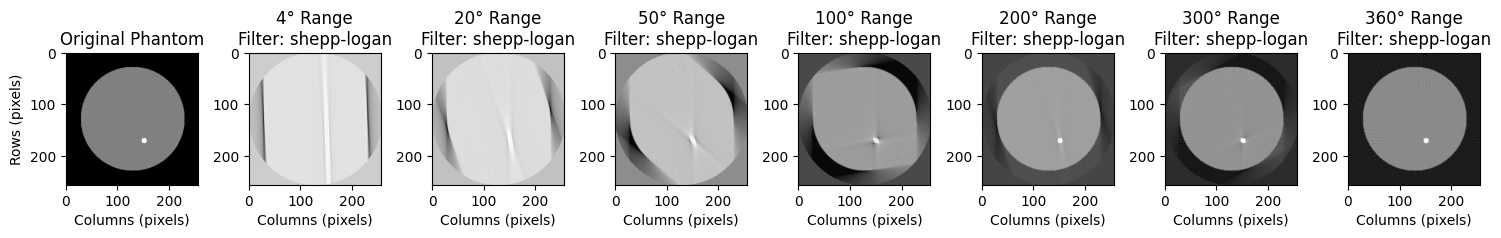

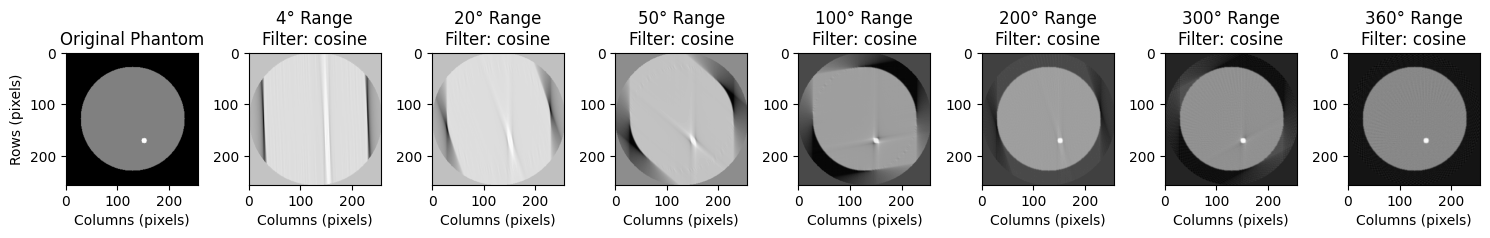

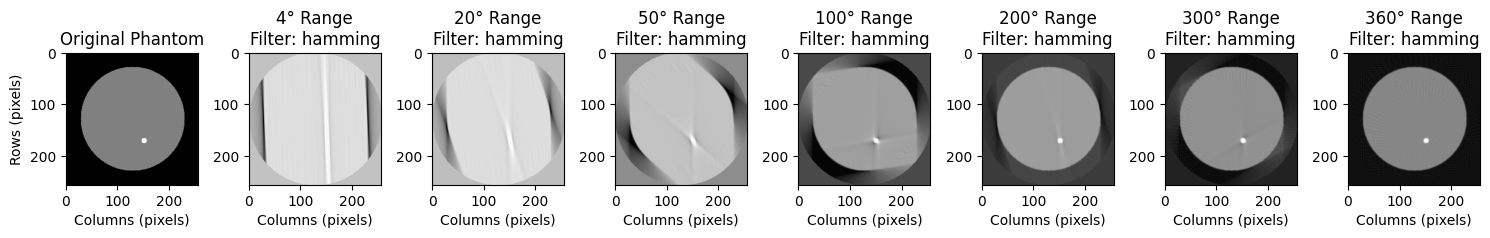

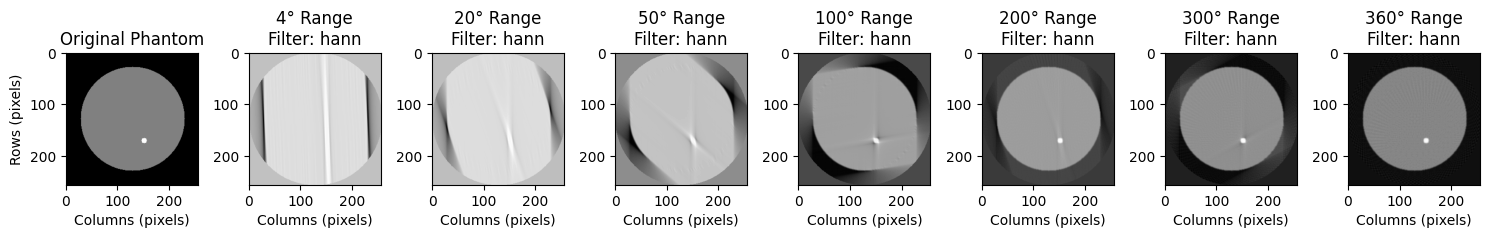

In [30]:
# Approach B: Varying Angular Range

angular_ranges = [4, 20, 50, 100, 200, 300, 360]

for filter_type in filters:
    fig, axes = plt.subplots(1, len(angular_ranges) + 1, figsize=(15, 5))  # +1 for the original phantom
    
    # Display original phantom
    axes[0].imshow(phantom, cmap='gray', extent=[0, w, h, 0])
    axes[0].set_title('Original Phantom')
    axes[0].set_xlabel('Columns (pixels)')
    axes[0].set_ylabel('Rows (pixels)')
    
    # Display reconstructed images
    for i, angular_range in enumerate(angular_ranges):
        theta = np.linspace(0., angular_range, 100, endpoint=False)  # 100 projections for each angular range
        sinogram = radon(phantom, theta=theta, circle=True)
        reconstruction = iradon(sinogram, theta=theta, filter_name=filter_type, circle=True)
        axes[i + 1].imshow(reconstruction, cmap='gray', extent=[0, w, h, 0])
        axes[i + 1].set_title(f'{angular_range}° Range\nFilter: {filter_type or "None"}')
        axes[i + 1].set_xlabel('Columns (pixels)')
    
    plt.tight_layout()
    plt.show()


For approach B, we can conclude that, as the angular range increases, the quality of the reconstructed image improves.

### 2.4 Compare the reconstructed signals (1.5 points)

Make use of the ``matplotlib`` to compare the original and reconstructed signals. In order to do so, make a single plot with the different pixel intensity profiles of the lesion (as done in 2.1). Then, discuss the results.

In [7]:
# insert your code here



### 2.5 Reconstructing noisy sinograms (2 points)

Add Poison noise (``np.random.poisson``; perhaps with lam = 10) to your previous sinograms and reconstruct the phantom images with the different filters. Plot the reconstruction image and the intensity profile along the lession. Then, comment on the effects of the filters on the reconstructed phatom images.

In [ ]:
# insert your code here



### 2.6 BONUS (OPTIONAL)

If you enjoyed the practicum and want to do more, I suggest you start again (perhaps with certain number of projections) with the Sheep-logan phantom as we discussed in the theory session.


In [6]:
from skimage.data import shepp_logan_phantom

image = shepp_logan_phantom()

# insert your code here